# Data Import

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=da541763b2ed3c4e8e72ba4f9884478e685d0ddae4cfc9ad2316be4ba2be94eb
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import wget
URL = "http://www.grip.unina.it/download/guide_TF/sign_detection.zip"
response = wget.download(URL, "sign_detection.zip")

In [3]:
import zipfile
with zipfile.ZipFile('sign_detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Homework

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from tensorflow import keras
from tensorflow.keras import layers
import sign_detection

In [5]:
(x_train,y_train),(x_val,y_val),(x_test,y_test) = sign_detection.load_data()

test 2: 100%|██████████| 400/400 [00:00<00:00, 2173.32it/s]


In [6]:
model = keras.models.Sequential() # initialize an empty network
layer1 = layers.Conv2D(8, (3,3), padding = 'same', activation = 'relu', input_shape = (32,32,3))
model.add(layer1) # adding layer1 to the network
layer2 = layers.MaxPooling2D((2,2))
model.add(layer2)
layer3 = layers.Conv2D(16, (3,3), padding = 'same', activation = 'relu') # valid crops the border, output is lower than input
model.add(layer3)
layer4 = layers.MaxPooling2D((2,2))
model.add(layer4)
layer5 = layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu') # valid crops the border, output is lower than input
model.add(layer5)
layer6 = layers.MaxPooling2D((2,2))
model.add(layer6)
layer7 = layers.Flatten() # flattens 3D structure into one vector -> 5x5x16 = 400
model.add(layer7)
layer8 = layers.Dense(512, activation = 'relu')
model.add(layer8)
layer9 = layers.Dense(3, activation = 'softmax')
model.add(layer9)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [7]:
# Keras works with float32 data. So, let us convert images to float, and normalize them so that values are between 0 and 1

x_test = np.float32(x_test) / 255.0
x_train = np.float32(x_train) / 255.0
x_val = np.float32(x_val) / 255.0

# Keras works with 4-dimensional matrices. Let us add one additional dimension so that each single image goes from (28x28) to (28,28,1)
# x_test = np.expand_dims(x_test, 3)
# x_train = np.expand_dims(x_train, 3)
# x_val = np.expand_dims(x_val, 3)

In [8]:
# Keras wants one-hot formatted labels.
# Basically, a vector of all 0s except one element which is 1 in correspondence of the index of the class the sample belongs to.
# 1 -> [1,0,0]
# 2 -> [0,1,0]
# 3 -> [0,0,1]

y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)
y_train = keras.utils.to_categorical(y_train)

### Tuning 'learning_rate' parameter

In [19]:
results = []
learning_rates = [0.001, 0.005, 0.01]

for lr in learning_rates:
  print('Learning Rate: {}'.format(lr))
  model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.SGD(learning_rate = lr),
              metrics = ['accuracy'])

  history = model.fit(x = x_train,
          y = y_train,
          epochs = 10,
          batch_size = 10,
          validation_data = (x_val, y_val),
          verbose = True)
  results.append(history.history['val_accuracy'][-1])

Learning Rate: 0.001
Epoch 1/10
360/360 [==============================] - 3s 6ms/step - loss: 8.2398e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9967
Epoch 2/10
360/360 [==============================] - 2s 5ms/step - loss: 8.1796e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9967
Epoch 3/10
360/360 [==============================] - 2s 6ms/step - loss: 8.1073e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9967
Epoch 4/10
360/360 [==============================] - 2s 5ms/step - loss: 8.0451e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 0.9967
Epoch 5/10
360/360 [==============================] - 2s 6ms/step - loss: 7.9715e-04 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9967
Epoch 6/10
360/360 [==============================] - 2s 6ms/step - loss: 7.9024e-04 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9967
Epoch 7/10
360/360 [==============================] - 2s 6ms/step - loss: 7.8485e-04 - accuracy: 1.0000

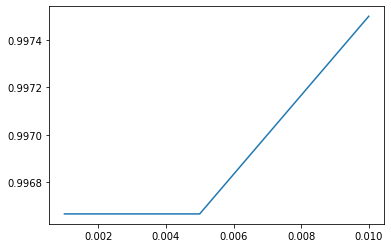

In [20]:
plt.figure()
plt.plot(learning_rates, results)
plt.show()

In [21]:
best_learning_rate = 0.01

### Tuning 'epochs' parameter

In [28]:
results = []
epochs_values = [5, 8, 10]

for epochs in epochs_values:
  print('Epochs: {}'.format(epochs))
  model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.SGD(learning_rate = best_learning_rate),
              metrics = ['accuracy'])

  history = model.fit(x = x_train,
          y = y_train,
          epochs = epochs,
          batch_size = 10,
          validation_data = (x_val, y_val),
          verbose = True)
  results.append(history.history['val_accuracy'][-1])

Epochs: 5
Epoch 1/5
360/360 [==============================] - 3s 6ms/step - loss: 8.6465e-05 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 0.9967
Epoch 2/5
360/360 [==============================] - 2s 7ms/step - loss: 8.5125e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9967
Epoch 3/5
360/360 [==============================] - 2s 6ms/step - loss: 8.3632e-05 - accuracy: 1.0000 - val_loss: 0.0081 - val_accuracy: 0.9967
Epoch 4/5
360/360 [==============================] - 2s 6ms/step - loss: 8.2158e-05 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 0.9967
Epoch 5/5
360/360 [==============================] - 2s 6ms/step - loss: 8.0946e-05 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9967
Epochs: 8
Epoch 1/8
360/360 [==============================] - 3s 6ms/step - loss: 8.0675e-05 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 0.9967
Epoch 2/8
360/360 [==============================] - 2s 5ms/step - loss: 7.8946e-05 - accuracy: 1.0000 - val_l

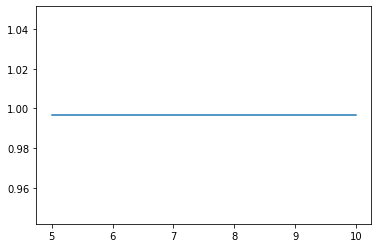

In [29]:
plt.figure()
plt.plot(epochs_values, results)
plt.show()

In [30]:
best_epochs_value = 5

### Tuning 'batch_size' parameter

In [31]:
results = []
batch_size_values = [8, 16, 32]

for batch_size in batch_size_values:
  print('Batch Size: {}'.format(batch_size))
  model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.SGD(learning_rate = best_learning_rate),
              metrics = ['accuracy'])

  history = model.fit(x = x_train,
          y = y_train,
          epochs = best_epochs_value,
          batch_size = batch_size,
          validation_data = (x_val, y_val),
          verbose = True)
  results.append(history.history['val_accuracy'][-1])

Batch Size: 8
Epoch 1/5
450/450 [==============================] - 3s 7ms/step - loss: 6.6526e-05 - accuracy: 1.0000 - val_loss: 0.0078 - val_accuracy: 0.9967
Epoch 2/5
450/450 [==============================] - 3s 6ms/step - loss: 6.4750e-05 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9967
Epoch 3/5
450/450 [==============================] - 3s 6ms/step - loss: 6.4806e-05 - accuracy: 1.0000 - val_loss: 0.0092 - val_accuracy: 0.9967
Epoch 4/5
450/450 [==============================] - 3s 7ms/step - loss: 6.4005e-05 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9967
Epoch 5/5
450/450 [==============================] - 3s 6ms/step - loss: 6.3537e-05 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9967
Batch Size: 16
Epoch 1/5
225/225 [==============================] - 2s 7ms/step - loss: 6.1124e-05 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 0.9967
Epoch 2/5
225/225 [==============================] - 1s 6ms/step - loss: 6.0791e-05 - accuracy: 1.000

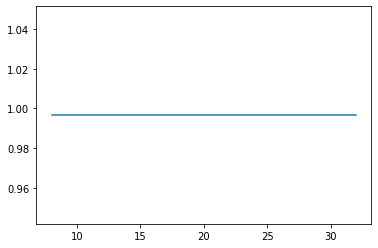

In [27]:
plt.figure()
plt.plot(batch_size_values, results)
plt.show()

In [32]:
best_batch_size = 32

### Final Model Training



In [33]:
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.SGD(learning_rate = best_learning_rate), # lr = 0.01
              metrics = ['accuracy'])

history = model.fit(x = x_train,
          y = y_train,
          epochs = best_epochs_value, # 5
          batch_size = best_batch_size, # 32
          validation_data = (x_val, y_val),
          verbose = True)

Epoch 1/5
113/113 [==============================] - 2s 9ms/step - loss: 5.7346e-05 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9967
Epoch 2/5
113/113 [==============================] - 1s 7ms/step - loss: 5.7379e-05 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9967
Epoch 3/5
113/113 [==============================] - 1s 7ms/step - loss: 5.7091e-05 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9967
Epoch 4/5
113/113 [==============================] - 1s 7ms/step - loss: 5.7058e-05 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9967
Epoch 5/5
113/113 [==============================] - 1s 7ms/step - loss: 5.6860e-05 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9967


### Test Performances

In [34]:
# Now we evaluate model performances on test data. the .evaluate() function returns the loss value and metrics for test data.

loss, acc = model.evaluate(x_test, y_test)
print(loss, acc)

38/38 [==============================] - 0s 4ms/step - loss: 0.0223 - accuracy: 0.9933
0.022322503849864006 0.9933333396911621


[1.0000000e+00 4.0275487e-30 5.4637789e-27]


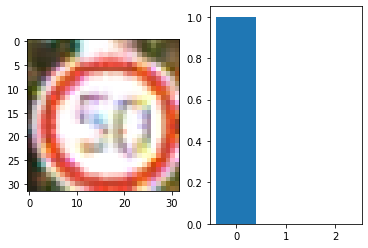

In [49]:
# Let us take one example to see how the model predicts its class label.

id = 100
img = x_test[id,:,:,:]
x = np.expand_dims(img, 0) # 1x28x28x1
p = model.predict(x) # 1x10 vector with probabilities
print(p[0,:])

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img, clim = [0,1])
plt.subplot(1,2,2)
plt.bar(np.arange(3), p[0])
plt.show()